<a href="https://colab.research.google.com/github/yonatansverdlov/E-GenNet/blob/master/k_chains_baselines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Propogating geometric information: $k$-chains

*Background:*
In geometric GNNs, **geometric information**, such as the relative orientation of local neighbourhoods, is propagated via summing features from multiple layers in fixed dimensional spaces.
The ideal architecture can be run for any number of layers to perfectly propagate geometric information without loss of information.
In practice, stacking geometric GNN layers may lead to distortion or **loss of information from distant nodes**.

*Experiment:*
To study the practical implications of depth in propagating geometric information beyond local neighbourhoods, we consider **$k$-chain geometric graphs** which generalise the examples from [Schütt et al., 2021](https://arxiv.org/abs/2102.03150).
Each pair of $k$-chains consists of $k+2$ nodes with $k$ nodes arranged in a line and differentiated by the orientation of the $2$ end points.
Thus, $k$-chain graphs are $(\lfloor \frac{k}{2} \rfloor + 1)$-hop distinguishable, and $(\lfloor \frac{k}{2} \rfloor + 1)$ geometric GNN iterations should be theoretically sufficient to distinguish them.
In this notebook, we train equivariant and invariant geometric GNNs with an increasing number of layers to distinguish $k$-chains.

Next, we wanted the impact of power graphs in garphs I-GGNN provably can't distinuish. For that we run the pairs of graphs in the figure (pairs). In Pair A, theoretically there's not enough information for distinguishment of $G_{1},G_{2}$, but ther's enough information in $G_{1}^{2},G_{2}^{2}$.
In Pair B, theoretically there's not enough information for distinguishment of $(G_{1},G_{2})$,$(G_{1}^{2},G_{2}^{2})$, but ther's enough information in $(G_{1}^{3},G_{2}^{3})$

In [ ]:
from google.colab import drive
import sys
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/')
sys.path.append('/content/drive/MyDrive/geometric_gnn/')


Mounted at /content/drive


In [ ]:
# Add this in a Google Colab cell to install the correct version of Pytorch Geometric.
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric
!pip install e3nn==0.4.4 ipdb ase

Looking in links: https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 35.4 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 13.9 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 7.2 MB/s eta 0:00:00
Looking in links: https://pytorch-geometric.com/whl/torch-2.2.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 943.4/943.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 387.7/387.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 18.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manyli

# Installation

# Imports

In [ ]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import torch
import torch_geometric
from torch_geometric.data import Data
import torch_geometric.loader as loader
from torch_geometric.utils import to_undirected
import e3nn
from functools import partial
import geometric_gnn
from geometric_gnn import experiments
import numpy as np

print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))
print("e3nn version {}".format(e3nn.__version__))
import geometric_gnn
from geometric_gnn import experiments
from experiments.utils.plot_utils import plot_2d, plot_3d
from experiments.utils.data import create_kchains,create_pairA,create_pairB
from experiments.utils.train_utils import run_experiment
from models.schnet import SchNetModel
from models.dimenet import DimeNetPPModel
from models.spherenet import SphereNetModel
from models.egnn import EGNNModel
from models.gvpgnn import GVPGNNModel
from models.tfn import TFNModel
from models.mace import MACEModel
# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

PyTorch version 2.2.1+cu121
PyG version 2.5.3
e3nn version 0.4.4
Using device: cpu


# Propogating geometric information: $k$-chains
In the first set of experiments we test the original $k$-chains for  $k$=12. Our aim is to examine long dependences of several models.
For that we run the desired model with increasing number of blocks and report the results.


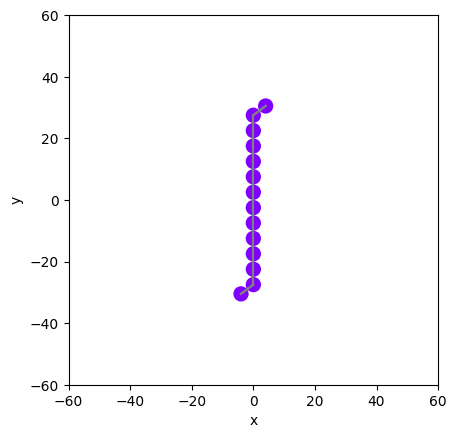

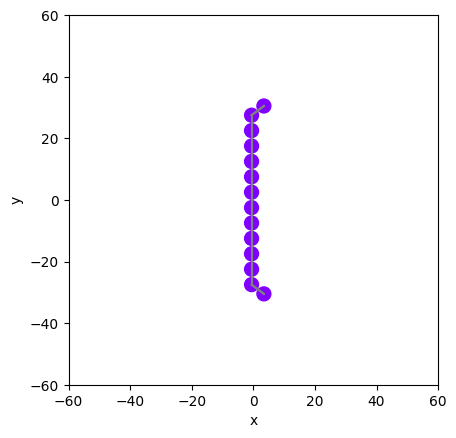

/usr/local/lib/python3.10/dist-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/jit/_check.py:177: UserWarning: The TorchScript type system doesn't support instance-level annotations on empty non-base types in `__init__`. Instead, either 1) use a type annotation in the class body, or 2) wrap the type in `torch.jit.Attribute`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/jit/_check.py:177: Us

  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
k = 12
ntimes = 10

# Create dataset
dataset = create_kchains(k=k)
for data in dataset:
    plot_2d(data, lim=60)

# Create dataloaders
dataloader = loader.DataLoader(dataset, batch_size=1)
val_loader = loader.DataLoader(dataset, batch_size=1)
test_loader = loader.DataLoader(dataset, batch_size=1)
# Set model
model_name = "MACE"

for num_layers in range(10 , 12):

    correlation = 2
    model = {
        "SchNet": SchNetModel,
        "dimenet": DimeNetPPModel,
        "spherenet": SphereNetModel,
        "EGNN": EGNNModel,
        "GVP": partial(GVPGNNModel, s_dim=32, v_dim=1),
        "TFN": TFNModel,
        "MACE": partial(MACEModel, correlation=correlation),
    }[model_name](num_layers=num_layers, in_dim=1, out_dim=2)

    best_val_acc_list, test_acc_list, train_time_list = run_experiment(
        model,
        dataloader,
        val_loader,
        test_loader,
        n_epochs=150,
        n_times=ntimes,
        device=device,
        verbose=False
    )
    print(f'\nDone! Averaged over {ntimes} runs of {model_name} with {num_layers} layers: \n '
          f'- Training time: {np.mean(train_time_list):.2f}s ± {np.std(train_time_list):.2f}. \n '
          f'- Best validation accuracy: {np.mean(best_val_acc_list):.3f} ± {np.std(best_val_acc_list):.2f}. \n'
          f'- Test accuracy: {np.mean(test_acc_list):.1f} ± {np.std(test_acc_list):.1f}. \n')

# Pairs seperation.


# Pair A.
In this section, we show the seperation ability of the model depending on the power graph. In this experiment, we show no I-GGNN can sepearte the first power $G^{1}$, but can $G^{2}$.

The power graph 1


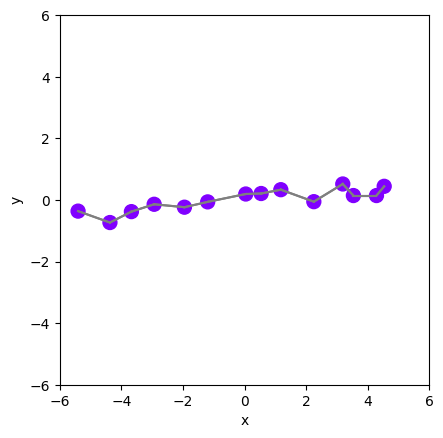

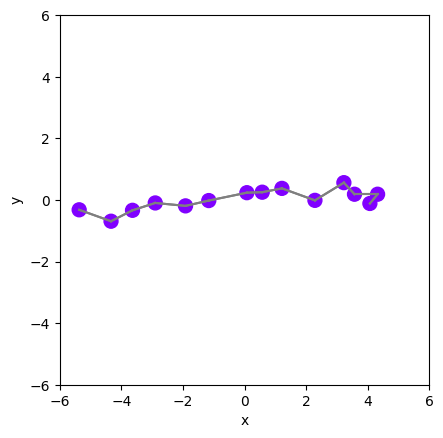


Number of layers: 5


  0%|          | 0/10 [00:00<?, ?it/s]


Done! Averaged over 10 runs of schnet with 5 layers, power graph 1: 
 - Training time: 7.70s ± 0.64. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 


Number of layers: 6


  0%|          | 0/10 [00:00<?, ?it/s]


Done! Averaged over 10 runs of schnet with 6 layers, power graph 1: 
 - Training time: 8.76s ± 0.53. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 

The power graph 2


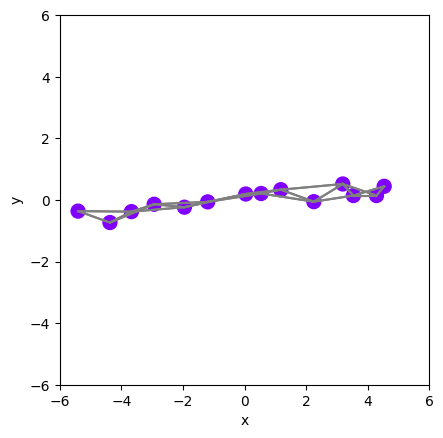

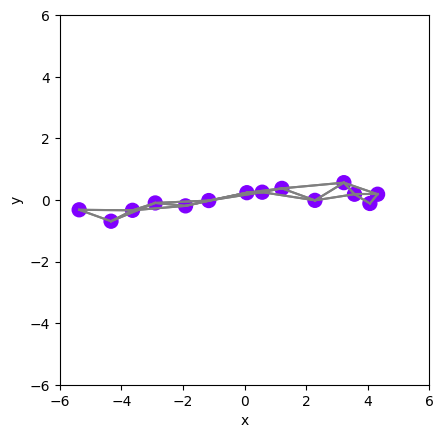


Number of layers: 5


  0%|          | 0/10 [00:00<?, ?it/s]


Done! Averaged over 10 runs of schnet with 5 layers, power graph 2: 
 - Training time: 8.76s ± 0.97. 
 - Best validation accuracy: 100.000 ± 0.000. 
- Test accuracy: 100.0 ± 0.0. 


Number of layers: 6


  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
ntimes= 10
k = 12

# Create dataset
for power in [1,2]:
  dataset = create_pairA(k=k,power = power)
  print(f"The power graph {power}")
  for data in dataset:
      plot_2d(data, lim=6.0)

  # Create dataloaders
  dataloader = loader.DataLoader(dataset, batch_size=1)
  val_loader = loader.DataLoader(dataset, batch_size=1)
  test_loader = loader.DataLoader(dataset, batch_size=1)
  # Set model
  model_name = "schnet"

  for num_layers in range(5 , 7):

      print(f"\nNumber of layers: {num_layers}")

      correlation = 2
      model = {
          "schnet": SchNetModel,
          "dimenet": DimeNetPPModel,
          "spherenet": SphereNetModel,
          "egnn": EGNNModel,
          "gvp": partial(GVPGNNModel, s_dim=32, v_dim=1),
          "tfn": TFNModel,
          "mace": partial(MACEModel, correlation=correlation),
      }[model_name](num_layers=num_layers, in_dim=1, out_dim=2)

      best_val_acc_list, test_acc_list, train_time_list = run_experiment(
        model,
        dataloader,
        val_loader,
        test_loader,
        n_epochs=150,
        n_times=ntimes,
        device=device,
        verbose=False
    )
      print(f'\nDone! Averaged over {ntimes} runs of {model_name} with {num_layers} layers, power graph {power}: \n '
          f'- Training time: {np.mean(train_time_list):.2f}s ± {np.std(train_time_list):.2f}. \n '
          f'- Best validation accuracy: {np.mean(best_val_acc_list):.3f} ± {np.std(best_val_acc_list):.3f}. \n'
          f'- Test accuracy: {np.mean(test_acc_list):.1f} ± {np.std(test_acc_list):.1f}. \n')

# Pair B
In this section, we show the seperation ability of the model depending on the power graph. In this experiment, we show no I-GGNN can sepearte the first power and second but third could be separated.

The power graph 1


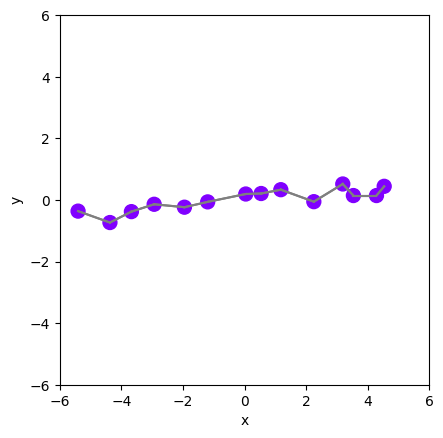

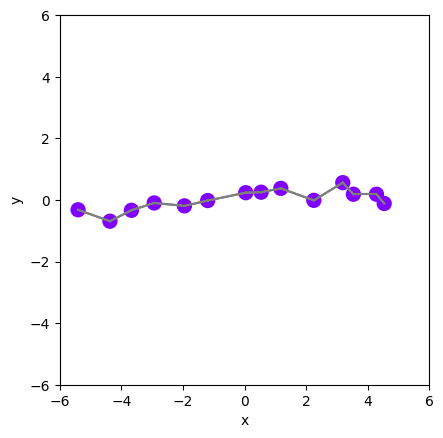


Number of layers: 5


  0%|          | 0/10 [00:00<?, ?it/s]


Done! Averaged over 10 runs of schnet with 5 layers, power graph 1: 
 - Training time: 7.98s ± 0.58. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 


Number of layers: 6


  0%|          | 0/10 [00:00<?, ?it/s]


Done! Averaged over 10 runs of schnet with 6 layers, power graph 1: 
 - Training time: 8.85s ± 0.72. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 

The power graph 2


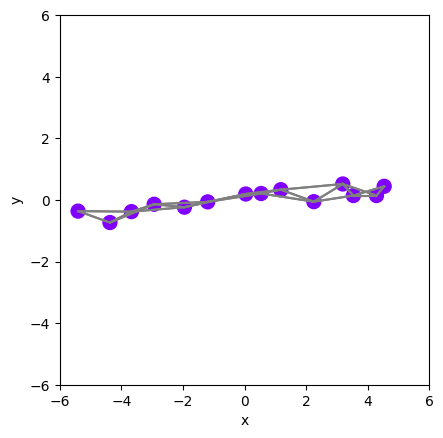

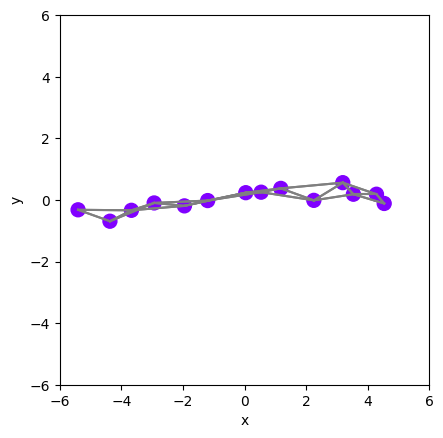


Number of layers: 5


  0%|          | 0/10 [00:00<?, ?it/s]


Done! Averaged over 10 runs of schnet with 5 layers, power graph 2: 
 - Training time: 8.27s ± 0.60. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 


Number of layers: 6


  0%|          | 0/10 [00:00<?, ?it/s]


Done! Averaged over 10 runs of schnet with 6 layers, power graph 2: 
 - Training time: 9.76s ± 0.72. 
 - Best validation accuracy: 50.000 ± 0.000. 
- Test accuracy: 50.0 ± 0.0. 

The power graph 3


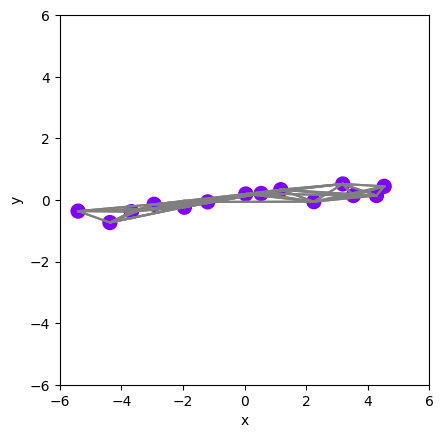

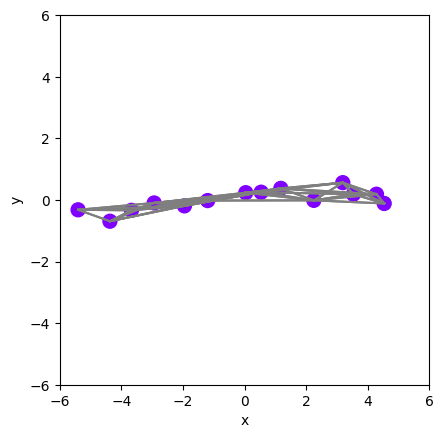


Number of layers: 5


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
ntimes= 10
k = 12

# Create dataset
for power in [1,2,3]:
  dataset = create_pairB(k=k,power = power)
  print(f"The power graph {power}")
  for data in dataset:
      plot_2d(data, lim=6.0)

  # Create dataloaders
  dataloader = loader.DataLoader(dataset, batch_size=1)
  val_loader = loader.DataLoader(dataset, batch_size=1)
  test_loader = loader.DataLoader(dataset, batch_size=1)
  # Set model
  model_name = "schnet"

  for num_layers in range(5 , 7):

      print(f"\nNumber of layers: {num_layers}")

      correlation = 2
      model = {
          "schnet": SchNetModel,
          "dimenet": DimeNetPPModel,
          "spherenet": SphereNetModel,
          "egnn": EGNNModel,
          "gvp": partial(GVPGNNModel, s_dim=32, v_dim=1),
          "tfn": TFNModel,
          "mace": partial(MACEModel, correlation=correlation),
      }[model_name](num_layers=num_layers, in_dim=1, out_dim=2)

      best_val_acc_list, test_acc_list, train_time_list = run_experiment(
        model,
        dataloader,
        val_loader,
        test_loader,
        n_epochs=150,
        n_times=ntimes,
        device=device,
        verbose=False
    )
      print(f'\nDone! Averaged over {ntimes} runs of {model_name} with {num_layers} layers, power graph {power}: \n '
          f'- Training time: {np.mean(train_time_list):.2f}s ± {np.std(train_time_list):.2f}. \n '
          f'- Best validation accuracy: {np.mean(best_val_acc_list):.3f} ± {np.std(best_val_acc_list):.3f}. \n'
          f'- Test accuracy: {np.mean(test_acc_list):.1f} ± {np.std(test_acc_list):.1f}. \n')